In [2]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback

from pathlib import Path
from livelossplot import PlotLossesKeras

In [6]:
# создание каталогов под классы
path = 'C:/Users/noname1209140143/code/emotions_generator_111/data'

base_dir = Path(path).parent / 'data'
train_dir = base_dir / 'train'
test_dir = base_dir / 'test'
val_dir = base_dir / 'val'

anger_dir = train_dir / 'anger'
disgust_dir = train_dir / 'disgust'
fear_dir = train_dir / 'fear'
happy_dir = train_dir / 'happy'
neutral_dir = train_dir / 'neutral'
sad_dir = train_dir / 'sad'
surprise_dir = train_dir / 'surprise'

anger_dir = test_dir / 'anger'
disgust_dir = test_dir / 'disgust'
fear_dir = test_dir / 'fear'
happy_dir = test_dir / 'happy'
neutral_dir = test_dir / 'neutral'
sad_dir = test_dir / 'sad'
surprise_dir = test_dir / 'surprise'

In [16]:
train = image_dataset_from_directory(directory = train_dir,
                                     label_mode = 'int',
                                     color_mode = 'grayscale',
                                     image_size = (64, 64),
                                     crop_to_aspect_ratio=True,
                                     shuffle=True)

Found 7000 files belonging to 7 classes.


In [17]:
test = image_dataset_from_directory(directory = test_dir,
                                    label_mode = 'int',
                                    color_mode = 'grayscale',
                                    image_size = (64, 64),
                                    crop_to_aspect_ratio=True,
                                    shuffle=True)

Found 777 files belonging to 7 classes.


In [18]:
# я следовал архитектуре u-net
inp = Input((64,64,1))

# вход нормализуется
norm_0 = Normalization()(inp)

# понижение размерности признакового пространсва
# свертки со страйдом вместо макспулинга
conv_0 = Conv2D(filters = 2, kernel_size = 3, padding='same', activation= 'relu')(norm_0)
mp_0 = MaxPooling2D()(conv_0)
conv_1 = Conv2D(filters = 4, kernel_size = 3, padding='same', activation= 'relu')(mp_0)
mp_1 = MaxPooling2D()(conv_1)
conv_2 = Conv2D(filters = 8, kernel_size = 3, padding='same', activation= 'relu')(mp_1)
mp_1 = MaxPooling2D()(conv_2)

# дилатационные свертки
dila_0 = Conv2D(filters = 16,kernel_size=3,padding='same',activation='relu',dilation_rate=6)(mp_1)
dila_1 = Conv2D(filters = 16,kernel_size=3,padding='same',activation='relu',dilation_rate=12)(mp_1)
dila_2 = Conv2D(filters = 16,kernel_size=3,padding='same',activation='relu',dilation_rate=18)(mp_1)

# склейка и перемешивание дилатационных сверток
concat_0 = Concatenate()([dila_0, dila_1, dila_2])
conv_1x1_0 = Conv2D(filters = 16, kernel_size = 3, padding='same', activation= 'relu')(concat_0)

# повышение размерности признакового пространсва и проброс инфы с более ранних слоев
trans_0 = Conv2DTranspose(filters=8,kernel_size=3,strides=2,padding='same',activation='relu')(conv_1x1_0)
concat_1 = Concatenate()([conv_2, trans_0])
trans_1 = Conv2DTranspose(4, (3, 3), strides=2, padding='same', activation='relu')(concat_1)
concat_2 = Concatenate()([conv_1, trans_1])
trans_2 = Conv2DTranspose(2, (3, 3), strides=2, padding='same', activation='relu')(concat_2)
concat_3 = Concatenate()([conv_0, trans_2])

drop = Dropout(0.0001)(concat_3)
flat = Flatten()(drop)
out = Dense(7, activation = 'softmax')(flat)

In [19]:
model = Model(inputs = inp, outputs = out)

In [20]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics = ['accuracy'])

In [21]:
# коллбек ловит val_loss на <=15%, останавливает сеть и сохраняет в файл
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss <= 0.1500:
            self.model.stop_training = True
            self.model.save('model.keras')

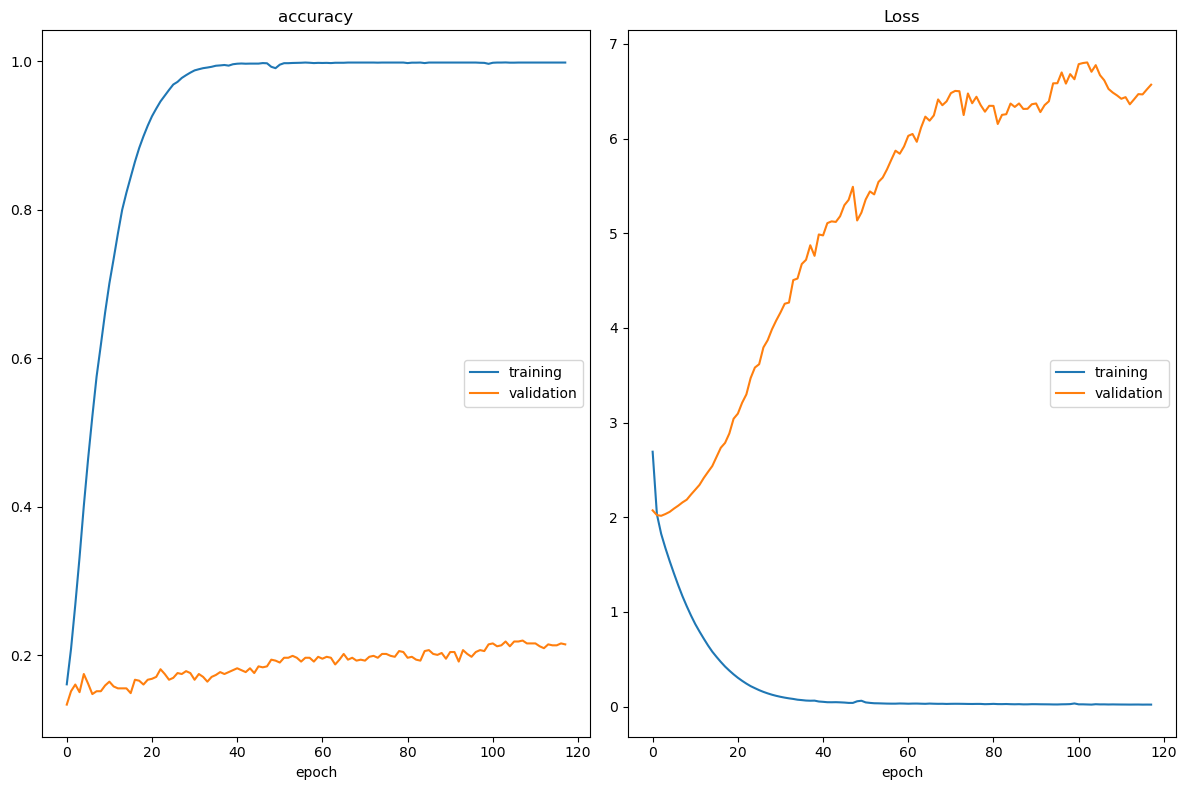

accuracy
	training         	 (min:    0.161, max:    0.998, cur:    0.998)
	validation       	 (min:    0.134, max:    0.220, cur:    0.215)
Loss
	training         	 (min:    0.021, max:    2.692, cur:    0.021)
	validation       	 (min:    2.016, max:    6.804, cur:    6.569)
219/219 [==============================] - 10s 46ms/step - loss: 0.0213 - accuracy: 0.9980 - val_loss: 6.5690 - val_accuracy: 0.2149
Epoch 119/200
141/219 [==================>...........] - ETA: 3s - loss: 0.0217 - accuracy: 0.9980

In [ ]:
history = model.fit(x = train,
                    epochs = 200,
                    validation_data = test,
                    # PlotLossesKeras() рисует график после каждой эпохи
                    callbacks=[PlotLossesKeras(), MyCallback()]
                   )